# Dois picos idênticos

In [3]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE
import seaborn as sns
from typing import Literal

In [60]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
ws[0] = ws[1]
t2s[0] = t2s[1]
M_0s[0] = M_0s[1]
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [61]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

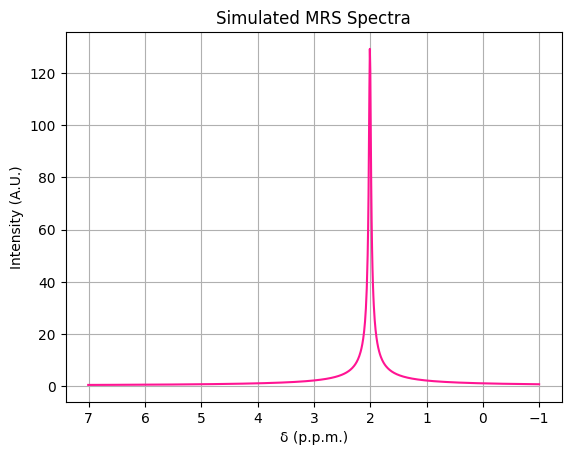

In [62]:
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [63]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [64]:
def rescale(arr : np.ndarray, min : float, max : float):
    return (arr - arr.min()) * (max - min) / (arr.max() - arr.min()) + min

In [65]:
size = 20
offsets = 10**(-(np.linspace(-3, size - 3 - 1, size)))
print(offsets)


[1.e+03 1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06
 1.e-07 1.e-08 1.e-09 1.e-10 1.e-11 1.e-12 1.e-13 1.e-14 1.e-15 1.e-16]


In [66]:
n_avgs = 10
L_ = int(L*2048)
shape = (offsets.size, n_avgs, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)

In [67]:
rerun = False
filename_end = ""
folder_name = "files/"
subfolder_name = "two_peaks/"

In [68]:
if rerun == True:
    for i in range(offsets.size):
        ws[1] = ws[0] + offsets[i]
        pop = pymri.population(ws, t2s, M_0s, spins_phi)

        sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)

        for j in range(n_avgs):
            f_sig, z, r = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]
            
            print(f"offset {offsets[i]} avg {j}")

In [69]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)

In [70]:
if rerun == False:
    s0s_ = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_ = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_ = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_ = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")

In [71]:
avg_s0 = np.average(s0s_, axis=1)
std_s0 = np.std(s0s_, axis=1)

avg_phi = np.average(phis_, axis=1)
std_phi = np.std(phis_, axis=1)

avg_omega = np.average(omegas_, axis=1)
std_omega = np.std(omegas_, axis=1)

avg_t2 = np.average(t2s_, axis=1)
std_t2 = np.std(t2s_, axis=1)

In [72]:
print(avg_omega.shape)
print(avg_s0.shape)

(20, 819)
(20, 819)


In [73]:
args = np.argsort(avg_s0, axis=1)
# print(args.shape)

i = 0


identified_s0 = np.sort(avg_s0[i, args[i, :]][L_ - 2: L_]) #filtra apenas os dois ultimos, correspondentes aos dois ultimos picos
identified_omega = np.sort(avg_omega[i, args[i, :]][L_ - 2: L_])
identified_phi = np.sort(avg_phi[i, args[i, :]][L_ - 2: L_])
identified_t2 = np.sort(avg_t2[i, args[i, :]][L_ - 2: L_])

identified_std_s0 = np.sort(std_s0[i, args[i, :]][L_ - 2: L_]) #filtra apenas os dois ultimos, correspondentes aos dois ultimos picos
identified_std_omega = np.sort(std_omega[i, args[i, :]][L_ - 2: L_])
identified_std_phi = np.sort(std_phi[i, args[i, :]][L_ - 2: L_])
identified_std_t2 = np.sort(std_t2[i, args[i, :]][L_ - 2: L_])

print("Offset")
print(offsets[i]) 
print("Original")
print(np.sort(np.array([ws[0], ws[0] + offsets[i]])))
print("Identificado \t\t\t Desvio Padrão")
print(identified_omega, "\t",identified_std_omega)
print("Erro")
print(np.sort(np.array([ws[0], ws[0] + offsets[i]])) - identified_omega)

Offset
1000.0
Original
[2411.71251655 3411.71251655]
Identificado 			 Desvio Padrão
[2411.71251655 3411.71251655] 	 [4.54747351e-13 4.54747351e-13]
Erro
[ 1.36424205e-12 -2.27373675e-12]


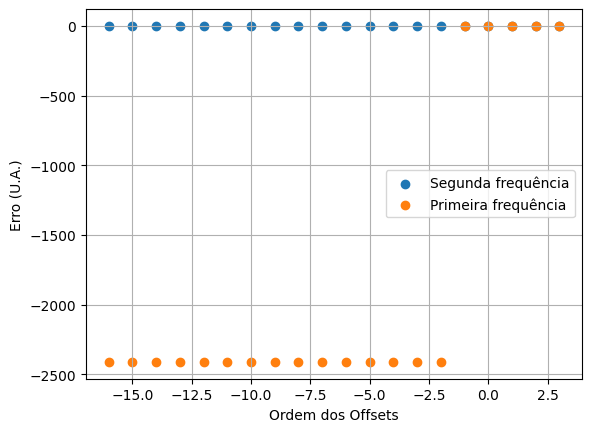

In [74]:
first_error, second_error = np.zeros_like(offsets), np.zeros_like(offsets)
for k in range(offsets.size):
    compare_arr = np.sort(avg_omega[k, args[k, :]][L_ - 2: L_])
    first_error[k] = compare_arr[0] - ws[0]
    second_error[k] = compare_arr[1] - (ws[0] + offsets[k])

# plt.figure(figsize=(10, 7))
plt.scatter(np.log10(offsets), second_error, label = f"Segunda frequência")
plt.scatter(np.log10(offsets), first_error, label = "Primeira frequência")
plt.xlabel("Ordem dos Offsets")
plt.ylabel("Erro (U.A.)")
plt.legend()
plt.grid()

Acima, é possível perceber que o limite de identificação de picos esbarra em 0.1Hz. Uma tese para esse limite é que a resolução da simulação é uma barreira: O sinal tem 2048 pontos, coletados no intervalo de tempo de 1s, o que da uma resolução de [-2048/2, 2048/2] Hz. Essas características configuram ao sinal resolução de 1Hz por ponto, perto da barreira a qual a identificação começa a falhar. Aparentemente o limite do algoritmo é a resolução do sinal.

REVISADO

Aparentemente o limite acima mencionado existe, mas com um porém: o formato dos picos importa. Outros testes foram rodados com picos de tamanhos diferentes e parece que foi possível identificar picos individuais além desse limite. Mais abaixo foram feitos testes para investigar isso.

In [75]:
identified_pop = pymri.population(identified_omega, identified_t2, identified_s0, identified_phi)

identified_sig, t = pymri.population_transverse_decay( t0, tn, dt, identified_pop, np.array([]) )
_, identified_sig_fft = pymri.fourier_spectrum(identified_sig, dt, B0)

([], [])

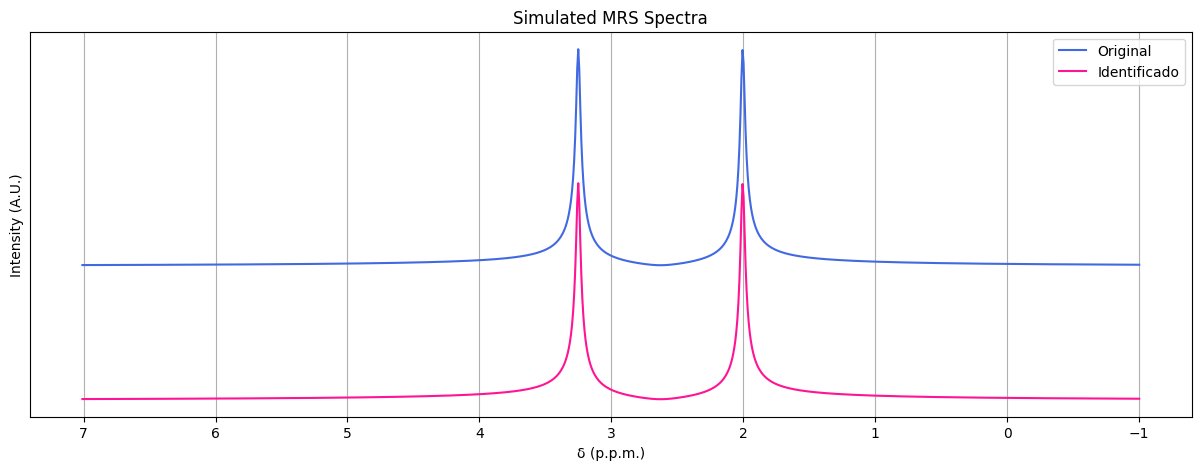

In [76]:
ws[1] = ws[0] + offsets[i]
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum(sig, dt, B0)

y_offset = 20.0

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, sig_fft, 1.0, y_offset=3*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, identified_sig_fft, 1.0, y_offset=y_offset, label="Identificado")
plt.legend()
plt.yticks([])

## Tamanho relativo entre os picos variado

In [77]:
size = 20
offsets = 10**(-(np.linspace(-3, size - 3 - 1, size)))
s0_offsets = np.arange(0.05, 1.05, 0.05)
print(s0_offsets)


[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


In [78]:
L_ = int(L*2048)
shape = (offsets.size, s0_offsets.size, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)

In [79]:
rerun = False
filename_end = "_peaks_change"
folder_name = "files/"
subfolder_name = "two_peaks/"

In [80]:
if rerun == True:
    for i in range(offsets.size):
        for j in range(s0_offsets.size):
            ws[1] = ws[0] + offsets[i]
            M_0s[1] = s0_offsets[j]*M_0s[0]
            pop = pymri.population(ws, t2s, M_0s, spins_phi)

            sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)

            f_sig, z, r = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]
            
            print(f"offset {offsets[i]} s0 {s0_offsets[j]}")

In [81]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)

In [82]:
if rerun == False:
    s0s_ = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_ = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_ = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_ = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")

In [83]:
print(s0s_.shape)

(20, 20, 819)


In [84]:
offset = 0
s0_offset = 9


args = np.argsort(s0s_, axis=2)
print(args.shape)



identified_s0 = np.sort(s0s_[offset, s0_offset, args[offset, s0_offset, :]][L_ - 2: L_]) #filtra apenas os dois ultimos, correspondentes aos dois ultimos picos
identified_omega = np.sort(omegas_[offset, s0_offset, args[offset, s0_offset, :]][L_ - 2: L_])
identified_phi = np.sort(phis_[offset, s0_offset, args[offset, s0_offset, :]][L_ - 2: L_])
identified_t2 = np.sort(t2s_[offset, s0_offset, args[offset, s0_offset, :]][L_ - 2: L_])

print(f"Offset de frequência {offsets[offset]} | Offset de S0 {s0_offsets[s0_offset]}")
print(offsets[i]) 
print("Original")
print(np.sort(np.array([ws[0], ws[0] + offsets[offset]])))
print("Identificado \t\t\t Desvio Padrão")
print(identified_omega, "\t",identified_std_omega)
print("Erro")
print(np.sort(np.array([ws[0], ws[0] + offsets[offset]])) - identified_omega)

(20, 20, 819)
Offset de frequência 1000.0 | Offset de S0 0.5
1000.0
Original
[2411.71251655 3411.71251655]
Identificado 			 Desvio Padrão
[2411.71251655 3411.71251655] 	 [4.54747351e-13 4.54747351e-13]
Erro
[4.54747351e-13 4.54747351e-13]


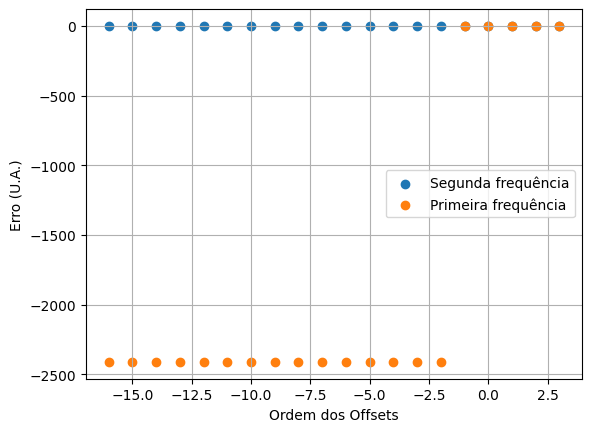

In [85]:
first_error, second_error = np.zeros_like(offsets), np.zeros_like(offsets)
for k in range(offsets.size):
    compare_arr = np.sort(omegas_[k, s0_offset, args[k, s0_offset, :]][L_ - 2: L_])
    first_error[k] = compare_arr[0] - ws[0]
    second_error[k] = compare_arr[1] - (ws[0] + offsets[k])

# plt.figure(figsize=(10, 7))
plt.scatter(np.log10(offsets), second_error, label = f"Segunda frequência")
plt.scatter(np.log10(offsets), first_error, label = "Primeira frequência")
plt.xlabel("Ordem dos Offsets")
plt.ylabel("Erro (U.A.)")
plt.legend()
plt.grid()

In [86]:
identified_pop = pymri.population(identified_omega, identified_t2, identified_s0, identified_phi)

identified_sig, t = pymri.population_transverse_decay( t0, tn, dt, identified_pop, np.array([]) )
_, identified_sig_fft = pymri.fourier_spectrum(identified_sig, dt, B0)

([], [])

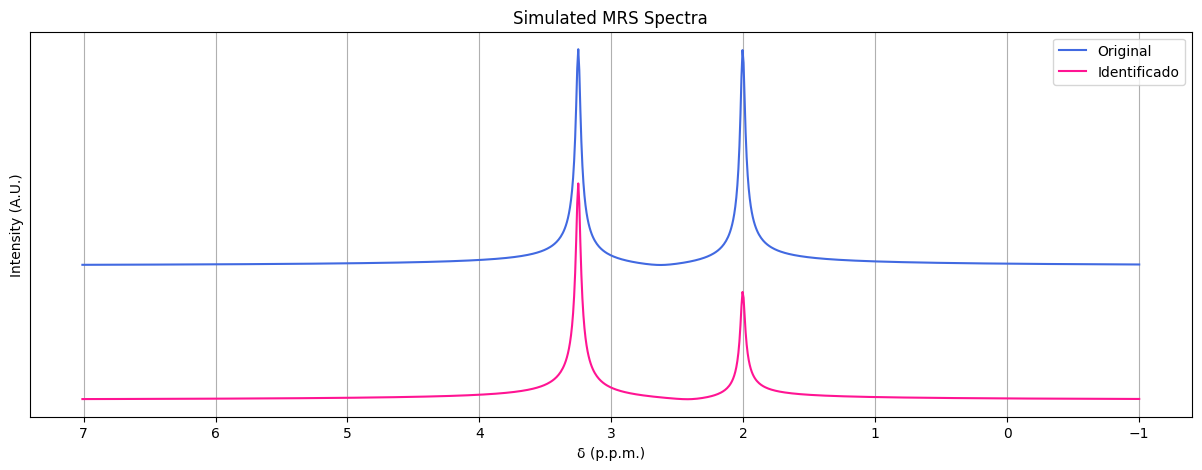

In [87]:
ws[1] = ws[0] + offsets[i]
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum(sig, dt, B0)

y_offset = 20.0

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, sig_fft, 1.0, y_offset=3*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, identified_sig_fft, 1.0, y_offset=y_offset, label="Identificado")
plt.legend()
plt.yticks([])

O tamanho do pico não importa. Talvez o T2 importe.

## Conclusão preliminar

A ideia de que o limite de detecção se ancora na resolução do sinal parece falsa. Nesse sinal, o limte da resolução é de $1 / Hz$, ou $\approx 6.28 / rad/s$, enquanto o método consegue detectar dois picos distintos apenas por $0.1 / rad/s$, ou $\approx 0.016 / Hz$. Sugere-se investigar melhor, talvez aumentando os parâmetros da própria simulação, como o tempo de simulação (aumentar o tn).

Outro fator importante de se comentar é que esse limite parece existir para dois picos de parâmetros idênticos diferindo apenas por um offset de frequência, porém foi verificado que para dois picos de parâmetros diferentes esse limite parece mudar significativamente.

# Dois picos diferentes

In [19]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
spins_phi = np.zeros_like(M_0s)

print("Freqs (rad/s),\t\t\t T_2s (s),\t\t M_0s (U.A.)")
print(ws, "\t", t2s, "\t", M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

Freqs (rad/s),			 T_2s (s),		 M_0s (U.A.)
[2355.21183064 2411.71251655] 	 [0.0199 0.0735] 	 [0.2917 0.4289]
All frequencies are captured by the sampling rate.


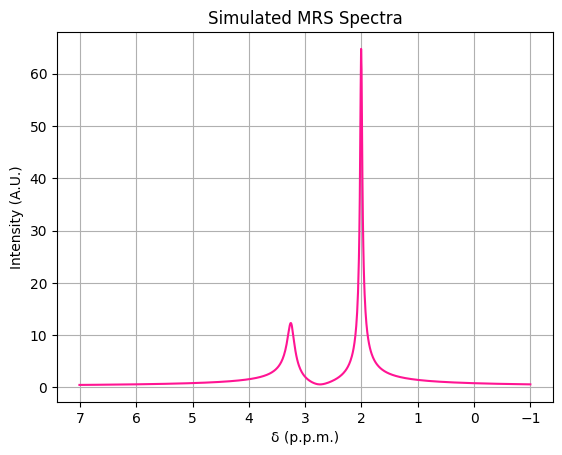

In [9]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [22]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [47]:
size = 20
offsets = 10**(-(np.linspace(-3, size - 3 - 1, size)))
t2_offsets = np.arange(0.05, 1.05, 0.05)
print(offsets)

[1.e+03 1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06
 1.e-07 1.e-08 1.e-09 1.e-10 1.e-11 1.e-12 1.e-13 1.e-14 1.e-15 1.e-16]


In [48]:
L_ = int(L*2048)
shape = (offsets.size, t2_offsets.size, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)

In [49]:
rerun = True
# filename_end = "_different_freqs"
filename_end = "_t2_offsets"
folder_name = "files/"
subfolder_name = "two_peaks/"

In [51]:
if rerun == True:
    for i in range(offsets.size):
        for j in range(t2_offsets.size):
            ws[0] = ws[1] + offsets[i]
            t2s[0] = t2s[1]*t2_offsets[j]
            M_0s[1] = M_0s[0]
            pop = pymri.population(ws, t2s, M_0s, spins_phi)

            sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)
            f_sig, z, r = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]
            
            print(f"offset {offsets[i]} t2 offset {t2_offsets[j]}")

offset 1000.0 t2 offset 0.05
offset 1000.0 t2 offset 0.1
offset 1000.0 t2 offset 0.15000000000000002
offset 1000.0 t2 offset 0.2
offset 1000.0 t2 offset 0.25
offset 1000.0 t2 offset 0.3
offset 1000.0 t2 offset 0.35000000000000003
offset 1000.0 t2 offset 0.4
offset 1000.0 t2 offset 0.45
offset 1000.0 t2 offset 0.5
offset 1000.0 t2 offset 0.55
offset 1000.0 t2 offset 0.6000000000000001
offset 1000.0 t2 offset 0.6500000000000001
offset 1000.0 t2 offset 0.7000000000000001
offset 1000.0 t2 offset 0.7500000000000001
offset 1000.0 t2 offset 0.8
offset 1000.0 t2 offset 0.8500000000000001
offset 1000.0 t2 offset 0.9000000000000001
offset 1000.0 t2 offset 0.9500000000000001
offset 1000.0 t2 offset 1.0
offset 100.0 t2 offset 0.05
offset 100.0 t2 offset 0.1
offset 100.0 t2 offset 0.15000000000000002
offset 100.0 t2 offset 0.2
offset 100.0 t2 offset 0.25
offset 100.0 t2 offset 0.3
offset 100.0 t2 offset 0.35000000000000003
offset 100.0 t2 offset 0.4
offset 100.0 t2 offset 0.45
offset 100.0 t2 offse

In [52]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)

In [ ]:
if rerun == False:
    s0s_ = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_ = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_ = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_ = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")

In [53]:
i = 9
t2_i = 0

args = np.argsort(s0s_, axis=2)

identified_s0 = np.sort(s0s_[i, t2_i, args[i, t2_i, :]][L_ - 2: L_]) #filtra apenas os dois ultimos, correspondentes aos dois ultimos picos
identified_omega = np.sort(omegas_[i, t2_i, args[i, t2_i, :]][L_ - 2: L_])
identified_phi = np.sort(phis_[i, t2_i, args[i, t2_i, :]][L_ - 2: L_])
identified_t2 = np.sort(t2s_[i, t2_i, args[i, t2_i, :]][L_ - 2: L_])

print("Offset")
print(offsets[i]) 
print("Original")
print(np.sort(np.array([ws[1], ws[1] + offsets[i]])))
print("Identificado \t\t\t Desvio Padrão")
print(identified_omega, "\t",identified_std_omega)
print("Erro")
print(np.sort(np.array([ws[1], ws[1] + offsets[i]])) - identified_omega)

Offset
1e-06
Original
[2411.71251655 2411.71251755]
Identificado 			 Desvio Padrão
[2411.71251655 2411.71251755] 	 [0. 0.]
Erro
[9.09494702e-13 4.54747351e-13]


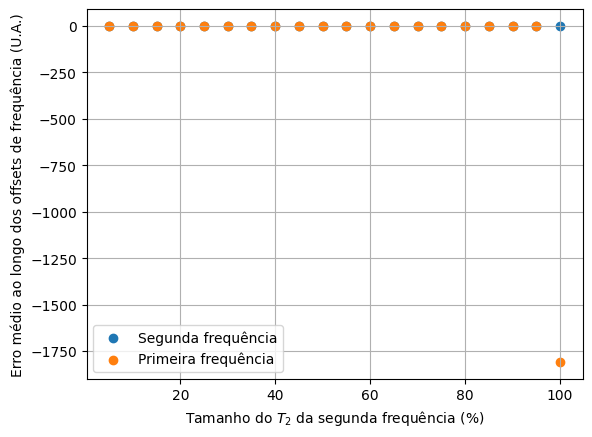

In [60]:
first_error, second_error = np.zeros((offsets.size, t2_offsets.size)), np.zeros((offsets.size, t2_offsets.size))
for j in range(t2_offsets.size):
    for k in range(offsets.size):
        compare_arr = np.sort(omegas_[k, j, args[k, j, :]][L_ - 2: L_])
        first_error[k, j] = compare_arr[0] - ws[1]
        second_error[k, j] = compare_arr[1] - (ws[1] + offsets[k])


plt.scatter(t2_offsets*100, np.average(second_error, axis = 0), label = f"Segunda frequência")
plt.scatter(t2_offsets*100, np.average(first_error, axis = 0), label = "Primeira frequência")
plt.xlabel(r"Tamanho do $T_2$ da segunda frequência (%)")
plt.ylabel("Erro médio ao longo dos offsets de frequência (U.A.)")
# plt.ylim(-10*1e-12, 10*1e-12)
plt.legend()
plt.grid()

# plt.figure(figsize=(10, 7))
# plt.scatter(np.log10(offsets), second_error, label = f"Segunda frequência")
# plt.scatter(np.log10(offsets), first_error, label = "Primeira frequência")
# plt.xlabel("Ordem dos Offsets")
# plt.ylabel("Erro (U.A.)")
# plt.ylim(-10*1e-12, 10*1e-12)
# plt.legend()
# plt.grid()